In [1]:
import mne
import numpy as np
import pandas as pd
import pathlib
import os
import h5py

In [2]:
os.environ["LABELS_DIRPATH"] = "labels"

import dataset_config as config
from data_functions.load import load_paper_labels
from generate_h5_from_labels import load_patient_data

In [3]:
dataset_dirpath = config.DATASET_DIRPATH
FILENAME = "chb01_01.edf"
PATIENT_NAME = FILENAME.split("_")[0]
dataset_dirpath/PATIENT_NAME/FILENAME

PosixPath('/media/marco741/Archive/Datasets/CHB MIT/chb06/chb06_16.edf')

In [4]:
y = load_paper_labels(config.NORMAL_LABELS_FILEPATH)
y = y[y["filename"] == FILENAME]

x = load_patient_data(dataset_dirpath/PATIENT_NAME/FILENAME, config.USEFUL_CHANNELS)



def load_paper_data(filepath: pathlib.Path, lazy=False):
    x_data = np.load(filepath, allow_pickle=True, mmap_mode='r' if lazy else None)
    return x_data

paper_x = load_paper_data(pathlib.Path("/media/marco741/Archive/Datasets/EEG data/normal_1_0_data_x.npy"), lazy=True)[y.index]

Extracting EDF parameters from /media/marco741/Archive/Datasets/CHB MIT/chb06/chb06_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Not setting metadata
3030 matching events found
No baseline correction applied
0 projection items activated
Loading data for 3030 events and 256 original time points ...


/home/marco741/Documents/Tesi/epilepsy_prediction/scripts/dataset/data_functions/edf.py:8: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_edf = mne.io.read_raw_edf(edf_path, stim_channel=None, include=useful_channels)  # type: ignore


0 bad epochs dropped


0.18557201 0.18557206 -4.4703484e-08 9.046725e-12
Creating RawArray with float64 data, n_channels=21, n_times=387840
    Range : 0 ... 387839 =      0.000 ...  3029.992 secs
Ready.
Using matplotlib as 2D backend.


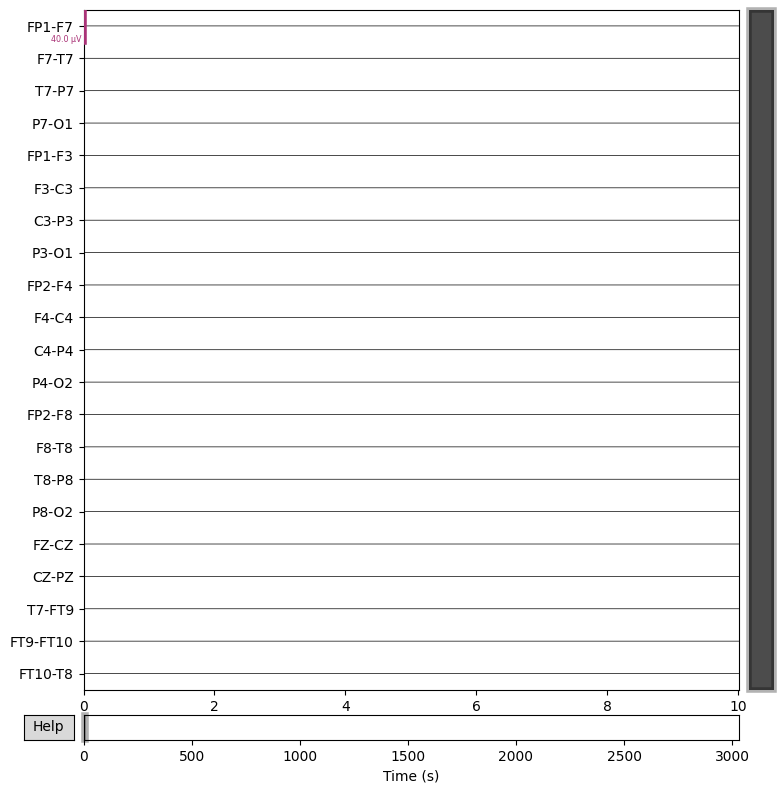

In [5]:
import mne

def adhoc_concatenation(x):
    x = np.concatenate(x, -1)
    return x

def plot_difference(x, paper_x):
    info=mne.create_info(ch_names=config.USEFUL_CHANNELS, sfreq=128, ch_types='eeg')
    np_diff = mne.io.RawArray((adhoc_concatenation(x) - adhoc_concatenation(paper_x))/1e6, info)
    p = np_diff.plot(n_channels=21)

print(paper_x.mean(), x.mean(), paper_x.mean() - x.mean(), ((paper_x - x)**2).mean())
plot_difference(x, paper_x)

In [23]:
new_filepath = pathlib.Path("/media/marco741/Archive/Datasets/testnewdataset/dataset.h5")
old_filepath = pathlib.Path("/media/marco741/Archive/Datasets/final/dataset.h5")

In [24]:
newf = h5py.File(new_filepath)
oldf = h5py.File(old_filepath)

chb06/train/X/4 27.182522 8029
Creating RawArray with float64 data, n_channels=21, n_times=1280
    Range : 0 ... 1279 =      0.000 ...     9.992 secs
Ready.


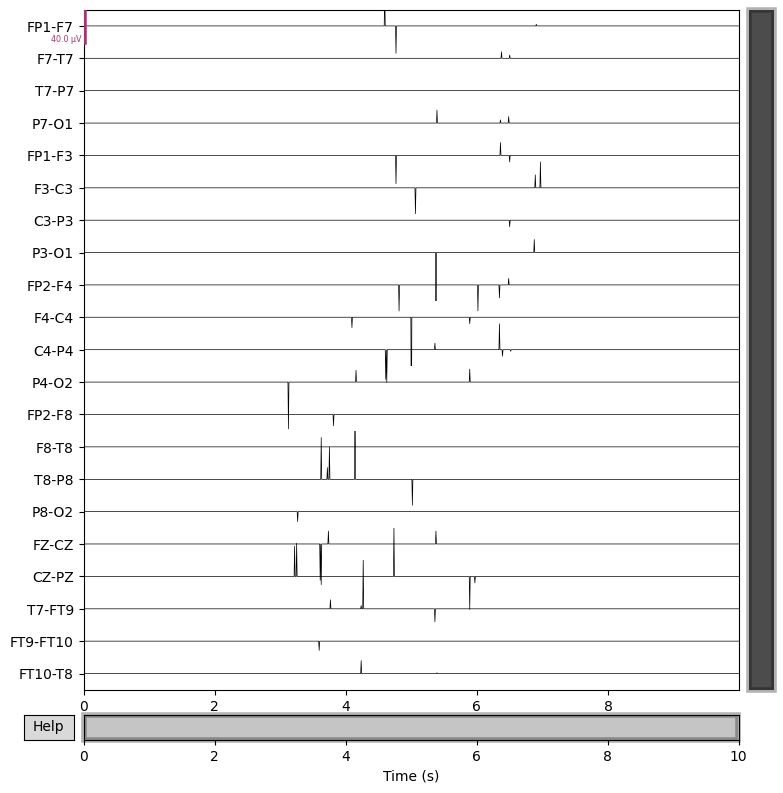

chb23/train/X/2 1.3280119 1449
Creating RawArray with float64 data, n_channels=21, n_times=1280
    Range : 0 ... 1279 =      0.000 ...     9.992 secs
Ready.


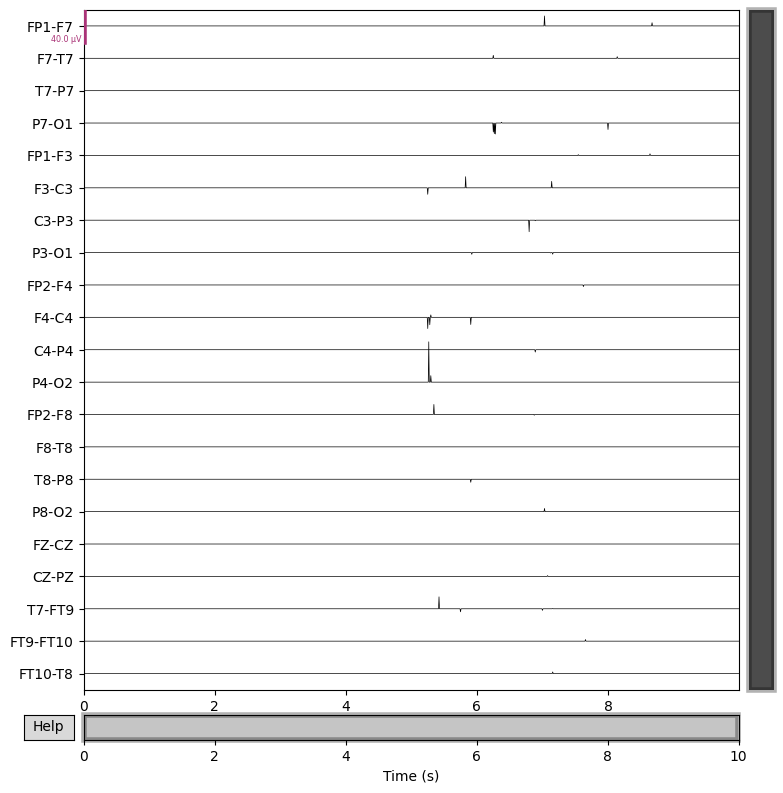

In [25]:
def visit(name, node):
    if isinstance(node, h5py.Dataset):
        if "/X/" in name:
            if ((node[:] - oldf[name][:])**2).mean() > 1e-9:
                argmax = ((node[:] - oldf[name][:])**2).mean(axis=(1,2)).argmax()
                print(name, ((node[:] - oldf[name][:])**2).mean(axis=(1,2)).max(), argmax)
                plot_difference(node[argmax-5:argmax+5], oldf[name][argmax-5:argmax+5])

newf.visititems(visit)